In [1]:
%matplotlib inline

from __future__ import division
import os
import sys
from scipy import integrate
from scipy.interpolate import interp2d, interp1d

import numpy as np
from numpy import pi,sin,cos,tan,e,arctan,arcsin,arccos,sqrt
from numpy.random import randn
import matplotlib
import matplotlib.pyplot as P
from time import clock


matplotlib.rcParams['figure.figsize'] = (7, 5)
P.rcParams['text.usetex'] = True  # not really needed
P.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
P.rcParams["font.size"] = 24
P.rc('xtick', labelsize=18) 
P.rc('ytick', labelsize=18)
# P.rc('xtick', labelsize=20) 
# P.rc('ytick', labelsize=20)
np.set_printoptions(threshold=np.nan)


sys.path.append("/Users/amadeus/Documents/10.semester/ma")
from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, W_tophat, T_obs, nutoz21, h
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, T_obs, nutoz21, h

sigma_8_BBKS = 0.833959881058


In [2]:
#preliminary, to be changed!!
bHI = 1
bgal = 1

lmin = 250; lmax = 25000 # lmin and lmax for Cl calculation
# lmin = 1; lmax = 1000 # lmin and lmax for Cl calculation
# ltab = np.arange(lmin,lmax)
# ltab = np.arange(lmin,lmax, 1000)
ltab = np.logspace(np.log10(lmin), np.log10(lmax), 25, dtype = int)
# ltab = np.array([280])

################################################
# ZhangPen:
zf = 0.75
dzf = 0.25
zfmin = zf - dzf; zfmax = zf + dzf

zb = (1.5 + 1.9)/2
dzb = 1.9 - zb
zbmin = zb - dzb; zbmax = zb + dzb
################################################



# ################################################
# zf = 0.3
# dzf = 0.005
# zfmin = zf - dzf; zfmax = zf + dzf

# zb = 1.5
# dzb = 0.01
# zbmin = zb - dzb; zbmax = zb + dzb
# ################################################



# zf = .1
# dzf = 0.06
# zfmin = zf - dzf; zfmax = zf + dzf

# zb = .4
# dzb = 0.06
# zbmin = zb - dzb; zbmax = zb + dzb

print "foreground from {} to {}".format(zfmin, zfmax)
print "background from {} to {}".format(zbmin, zbmax)

foreground from 0.5 to 1.0
background from 1.5 to 1.9


Some functions as defined in Alkistis' notes:

In [3]:
def sg(z): #number count slope. Fit taken from eq 23 in 1611.01322v2
    n0 = 0.132
    n1 = 0.259
    n2 = -0.281
    n3 = 0.691
    n4 = -0.409
    n5 = 0.152
    
    return n0 + n1*z + n2*z**2 + n3*z**3 + n4*z**4 + n5*z**5
    

#old and very slow:
def g_slow(z,zcenter, halfzwidth): #lensing kernel
    """zb is background redshift"""
    zmin = zcenter - halfzwidth
    zmax = zcenter + halfzwidth
    integral = integrate.quad(lambda zint: 
                              (rCom(zint) - rCom(z))/rCom(zint) * W_tophat(zint, zmin, zmax)
                              ,z
                              ,zmax,
                              full_output=1)[0]
    return rCom(z) * integral




# difficult to do quick integration because integration limit appears inside the integral. Therefore we split it up!
# def g_cumtrapz(z, zb, dzb, NINT = 2000):
def g(z, zb, dzb, NINT = 10000): #new standard to use cumtrapz
    """compare to my (handwritten) notebook 2 entry for 9/3/17
    zb is background redshift"""
    zmin = zb - dzb
    zmax = zb + dzb
    z = np.atleast_1d(z)
    zintmin = 1e-3 #lower integration limit, z must not be smaller than this
    if (z>zmax).any() or (z<zintmin).any():
        raise ValueError("z either lies behind the background or is too small! z = {} to {}".format(np.amin(z), np.amax(z)))
        
    zint = np.linspace(zmax, zintmin, NINT) #going reverse, multiply integral with -1
    Warray = W_tophat(zint, zmin, zmax)
    rarray = rCom(zint)
    Wbyrarray = Warray/rarray
    
    integrand1 = Warray
    integrand2 = Wbyrarray
        
    integral1 = -integrate.cumtrapz( integrand1, zint, initial = 0)
    integral2 = -integrate.cumtrapz( integrand2, zint, initial = 0)
    
    val1 = interp1d(zint[::-1], integral1[::-1], kind='linear', bounds_error=False)
    val2 = interp1d(zint[::-1], integral2[::-1], kind='linear', bounds_error=False)
    
    rComtab = rCom(z)
    result = rComtab*(val1(z) - rComtab*val2(z))
    return result


def Cl_HIxmag_BBKS(ltable, zf, zb, delta_zf, Nint = 500):
    #note there is no T_obs factor because we want to compare with galaxy case
    fac1 = 3/2 * (H_0/c)**2 * Omega_m #no square on (H_0/c) because it cancels out
    fac2 = bHI * (5*sg(zb) - 2)
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
#     gtab = [g(zz, zb, dzb) for zz in ztab] # this is slow
    gtab = g(ztab, zb, dzb)
    
    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        integrand[:,il]= (1+ztab) * W_tophat(ztab, zfmin, zfmax) * gtab / rCom(ztab)**2 * P_cdm_BBKS(( ell)/rCom(ztab)) * D_z(ztab)**2
    result= fac1 * fac2 * np.trapz(integrand,ztab,axis=0)
    return result

def Cl_HIxmag_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
    """ltable, zf foreground redshift, zb background redshift, 
    delta_zf foreground redshift widht, Nint integration steps"""

    #note there is no T_obs factor because we want to compare with galaxy case
    fac1 = 3/2 * bHI*(H_0/c)**2 * Omega_m #no square on (H_0/c) because it cancels out
    fac2 = bHI * (5*sg(zb) - 2)
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf

    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        pknltab = np.array([pknl(( ell)/rCom(zzz), zzz) for zzz in ztab])
        integrand[:,il] = (1+ztab) * W_tophat(ztab, zfmin, zfmax) * g(ztab, zb, dzb) \
        / rCom(ztab)**2 * pknltab

        #old and slow ways to calculate the same thing:
#             integrand[:,il]= np.array([(1+zzz) * W_tophat(zzz, zfmin, zfmax) * g(zzz, zb, dzb) \
#                                        / rCom(zzz)**2 * pknl(( ell)/rCom(zzz), zzz) for zzz in ztab])
#         integrand[:,il]= np.array([(1+zzz) * W_tophat(zzz, zfmin, zfmax) * g(zzz, zb, dzb) * rCom(zzz) * pknl(( ell)/rCom(zzz), zzz) for zzz in ztab]) #different factor of chi than in alkistis' notes (units are wrong there)
    result= fac1 * fac2 * np.trapz(integrand,ztab,axis=0)
    return result

                        

In [4]:
# #benchmarking:

# zb = 1
# dzb = 0.3
# ztab = np.linspace(0.1,1.3,500)

# st = clock()
# gtab = np.array([g_slow(zz, zb, dzb) for zz in ztab])
# end = clock()

# st2 = clock()
# gtab2 = g(ztab, zb, dzb)
# end2 = clock()

# print end-st, end2-st2

# fig = P.figure(); ax = fig.add_subplot(111);
# ax.semilogy(ztab, np.abs(gtab - gtab2)/gtab)


From ZiourHui:

In [5]:
#two ways to compute the same thing:

def Cl_delkap2_BBKS(ltable, zf, zb, delta_zf, Nint = 500):
    fac = bHI * (5*sg(zb) - 2)
    return Cl_HIxmag_BBKS(ltable, zf, zb, delta_zf, Nint = Nint) / fac

def Cl_delkap_BBKS(ltable, zf, zb, delta_zf, Nint = 500):
    fac = 3/2 * (H_0/c)**2 * Omega_m
    
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
#     gtab = [g(zz, zb, dzb) for zz in ztab] # this is slow
    gtab = g(ztab, zb, dzb)
    
    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        integrand[:,il]= (1+ztab) * W_tophat(ztab, zfmin, zfmax) * gtab / rCom(ztab)**2 * P_cdm_BBKS(( ell)/rCom(ztab)) * D_z(ztab)**2
    result= fac * np.trapz(integrand,ztab,axis=0)
    return result




def Cl_delkap2_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
    fac = bHI * (5*sg(zb) - 2)
    return Cl_HIxmag_CAMB(ltable, zf, zb, delta_zf, Nint = Nint) / fac

def Cl_delkap_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
    fac = 3/2 * (H_0/c)**2 * Omega_m
    
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
#     gtab = [g(zz, zb, dzb) for zz in ztab] # this is slow
    gtab = g(ztab, zb, dzb)
    
    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        integrand[:,il]= [(1+zzz) * W_tophat(zzz, zfmin, zfmax) * gtab / rCom(zzz)**2 * pknl(( ell)/rCom(zzz), zzz) for zzz in ztab]
    result= fac * np.trapz(integrand,ztab,axis=0)
    return result

Galaxy and HI autocorrelation Cls:

In [6]:
def C_l_HIHI_BBKS(ltable,zmin,zmax, Nint = 500):
    """arguments: ell array, zmin, zmax
    returns: Cl as array"""
    ztable = np.linspace(zmin, zmax, Nint)
    integrand=np.zeros([len(ztable),len(ltable)])
    for l in range(len(ltable)):
        #for the moment we divide out T_obs to compare with the galaxy results
        integrand[:,l]=E_z(ztable)*(W_tophat(ztable,zmin,zmax)*D_z(ztable)/rCom(ztable))**2*P_cdm_BBKS((ltable[l])/rCom(ztable))
    result=bHI* H_0/c*np.trapz(integrand,ztable,axis=0)
    return result


def C_l_gg_BBKS(ltable,zmin,zmax, Nint = 500):
    """arguments: ell array, zmin, zmax
    returns: Cl as array"""
    ztable = np.linspace(zmin, zmax, Nint)
    integrand=np.zeros([len(ztable),len(ltable)])
    for l in range(len(ltable)):
        integrand[:,l]=E_z(ztable)*(W_tophat(ztable,zmin,zmax)*D_z(ztable)/rCom(ztable))**2*P_cdm_BBKS((ltable[l])/rCom(ztable))
    result=bgal* H_0/c*np.trapz(integrand,ztable,axis=0)
    return result


Interpolate the nonlinear P(k) from Alkistis and use it to calculate Cls:

In [7]:
pknl_root = "./PkNL/"
filelist =  np.sort(os.listdir(pknl_root))
print "CHECK IF THIS IS IN ORDER:"
print filelist
zc_pk = np.linspace(0,4,len(filelist))
# print zc_pk

k_pk = np.loadtxt(pknl_root + filelist[0], unpack = True)[0]

pknl_arr = np.array([ np.loadtxt(pknl_root + fi, unpack = True)[1] for fi in filelist ])

pknl_int = interp2d( k_pk, zc_pk, pknl_arr)

def pknl(kk, zz):
    res = pknl_int(kk/h, zz)/h**3
    if len(res) == 1:
        return res[0]
    else:
        return res

    

# #test it:

# for zi in range(len(zc_pk)):
#     for ki in range(len(k_pk)):
#         pppk_at_z = np.array( np.loadtxt(pknl_root + filelist[zi], unpack = True)[1])
#         print pppk_at_z[ki] - pknl(k_pk[ki], zc_pk[zi])



def C_l_HIHI_CAMB(ltable,zmin,zmax, Nint = 500):
    """arguments: ell array, zmin, zmax
    returns: Cl as array"""
    ztable = np.linspace(zmin, zmax, Nint)
    integrand=np.zeros([len(ztable),len(ltable)])
    for l in range(len(ltable)):
        #for the moment we divide out T_obs to compare with the galaxy results
#         integrand[:,l]=E_z(ztable)*(W_tophat(ztable,zmin,zmax)/rCom(ztable))**2*pknl((ltable[l])/rCom(ztable), ztable)
        integrand[:,l]= np.array([E_z(zzz)*(W_tophat(zzz,zmin,zmax)/rCom(zzz))**2*pknl((ltable[l])/rCom(zzz), zzz) for zzz in ztable])
    result=bHI* H_0/c*np.trapz(integrand,ztable,axis=0)
    return result

def C_l_gg_CAMB(ltable,zmin,zmax, Nint = 500):
    """arguments: ell array, zmin, zmax
    returns: Cl as array"""
    ztable = np.linspace(zmin, zmax, Nint)
    integrand=np.zeros([len(ztable),len(ltable)])
    for l in range(len(ltable)):
        integrand[:,l]=np.array([E_z(zzz)*(W_tophat(zzz,zmin,zmax)/rCom(zzz))**2*pknl((ltable[l])/rCom(zzz), zzz) for zzz in ztable])
    result=bgal* H_0/c*np.trapz(integrand,ztable,axis=0)
    return result


CHECK IF THIS IS IN ORDER:
['Pk_z0.dat' 'Pk_z0p2.dat' 'Pk_z0p4.dat' 'Pk_z0p6.dat' 'Pk_z0p8.dat'
 'Pk_z1.dat' 'Pk_z1p2.dat' 'Pk_z1p4.dat' 'Pk_z1p6.dat' 'Pk_z1p8.dat'
 'Pk_z2.dat' 'Pk_z2p2.dat' 'Pk_z2p4.dat' 'Pk_z2p6.dat' 'Pk_z2p8.dat'
 'Pk_z3.dat' 'Pk_z3p2.dat' 'Pk_z3p4.dat' 'Pk_z3p6.dat' 'Pk_z3p8.dat'
 'Pk_z4.dat']


Signal to noise:

In [8]:
def DELTA_Cl_HIxmag(ltable, zf, dzf, zb, dzb, PERFECT_SURVEY = 1, BBKS = False):
    

    zfmin = zf - dzf; zfmax = zf+dzf
    zbmin = zb-dzb; zbmax = zb+dzb

    if BBKS:
        ClHIHIfunc = C_l_HIHI_BBKS
        Cl_HIxmagfunc = Cl_HIxmag_BBKS
        Clggfunc = C_l_gg_BBKS
    else:
        ClHIHIfunc = C_l_HIHI_CAMB
        Cl_HIxmagfunc = Cl_HIxmag_CAMB
        Clggfunc = C_l_gg_CAMB

    #perfect survey:
    if PERFECT_SURVEY:
        Cshot = np.zeros(len(ltable)); N_ell = np.zeros(len(ltable)); 
        fsky = 1; d_ell = 1;

    else:
        return ValueError("only perfect survey implemented")
    X2 = Cl_HIxmagfunc(ltable, zf, zb, dzf)**2
    HIHI = ClHIHIfunc(ltable, zfmin, zfmax) + Cshot
    gg = Clggfunc(ltable, zbmin, zbmax) + N_ell
    num = X2 + HIHI*gg
    denom = (2*ltable+1) * d_ell * fsky
    result = np.sqrt(num/denom)
    return result

def S2N(ltable, zf, dzf, zb, dzb, PERFECT_SURVEY = 1):
    delt = DELTA_Cl_HIxmag(ltable, zf, dzf, zb, dzb, PERFECT_SURVEY = PERFECT_SURVEY)
    signal = Cl_HIxmag_CAMB(ltable, zf, zb, dzb)
    return signal/delt

Compare HIHI Cls with Fig 2 in Bingo paper:

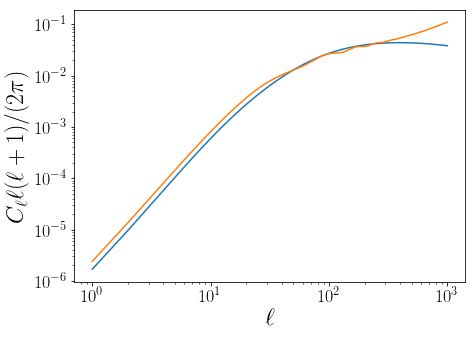

In [9]:
#compare with Fig 2 in Bingo paper:
lbing = np.arange(1,1000)

Cl_HIHI = C_l_HIHI_BBKS(lbing, nutoz21(975), nutoz21(925))
Cl_HIHI_camb = C_l_HIHI_CAMB(lbing, nutoz21(975), nutoz21(925))

fig = P.figure(); ax = fig.add_subplot(111);
ax.loglog(lbing, Cl_HIHI*(lbing+1)*lbing / 2 / pi)
ax.loglog(lbing, Cl_HIHI_camb*(lbing+1)*lbing / 2 / pi)

ax.set_xlabel("$\ell$")
ax.set_ylabel("$C_\ell\ell(\ell+1)/(2\pi)$")
P.show()

which matches perfectly (BBKS case). The CAMB power spectrum seems to have different normalization... check sigma_8 maybe?

We want to compare Alkistis' notes to the Zhang&Pen paper. For that we first need a few more functions:

In [98]:
#The total 21 cm flux of HI rich galaxies:
def S21(z, MHI):
    """from eq 1 in Zhang&Pen. returns in mJy, MHI has to be [10^10 solar masses]
    we assume w = 100km/s!"""
    return 0.023 * MHI/10**10 * (c / H_0 / rCom(z))**2 * 1 / (1+z) #rCom should be "comoving angular distance". not sure if that's right

#the system temperature per beam:
def Ssys(z, experiment):
    """experiment is a dict"""
    Tsys = experiment["Tsys"] #[K]
    Aeff = experiment["Aeff"] #[m^2]
    t_int = experiment["t_int"] #[hours] for each FOV!
    
    fac1 = 0.032 * Tsys / 30
    fac2 = 5e4/Aeff
    fac3 = np.sqrt( (1+z)/t_int )
    return fac1 * fac2 * fac3

n_0 = 0.014 * h**3 #[Mpc^-3]
Mstar = 10**9.55 * h**(-2) #[solar masses]
gamma = 1.2

#schechter function, equation 4:
def n_schechter(M):
    """we set z=0!"""
    fac1 = (M/Mstar)**(-gamma)
    fac2 = np.exp( -M / Mstar)
    return n_0 * fac1 * fac2
    
def M_HI_min(z, F): #minimum hydrogen mass in galaxy to be detected
    """z redshift, F is flux limit for detection, F = Ssys*n. Derivation of this is based on
    equations 3 and 2, done in amadeus' handwritten notes on 23rd of march
    """
    fac1 = 1.39 * 10**10 * (rCom(z) * H_0 / c)**2 * (1+z)
    fac2 = F / 0.032
    
    return fac1 * fac2


def nrho_HI(z, F, Nint = 2000):
    """density of HI galaxies with flux bigger than F. NOTE: 
    """
    F = np.atleast_1d(F)
    M_HI_lim = M_HI_min(z, F)

    Mint_by_Mstar = np.logspace(2,-6,Nint) #runs backwards
    Mint = Mint_by_Mstar * Mstar
    integrand = n_schechter(Mint)

    integral = integrate.cumtrapz( -integrand, Mint, initial = 0)
    val = interp1d(Mint[::-1], integral[::-1], kind='linear', bounds_error=False)


    rho_lim = val(M_HI_lim)

#     return rho_lim
    return rho_lim/Mstar    #this is not what is written in the paper, 
                            #but it reproduces their results perfectly. I suspect a typo.. (dM should be dM/M*)

def nrho_HIprime(z, F, delta = 2e-4):
    """delta is the step length in the derivative"""
    F = np.atleast_1d(F)
    Fdelta = F * delta
    Fplus = F + Fdelta
    Fminus = F - Fdelta
    rhoplus = nrho_HI(z, Fplus)
    rhominus = nrho_HI(z, Fminus)
    return (rhoplus - rhominus)/2/Fdelta


def dNdz(z, n, experiment, Nderiv = 1000):
    """derivative of abundance of 21cm emitting galaxies wrt z.
    for explanation of Fdelta look up N_HI"""
    z = np.atleast_1d(z)
    F = n * Ssys(z, experiment)

    solidangle = experiment["S_area"] * (pi/180)**2
    
    radius = rCom #comoving
#     radius = lambda zzz: rCom(zzz)/(1+zzz) #physical
    
    rtab2 = radius(z)**2
    
    #for derivative:
    zmin = 0.
    zmax = np.amax(z) + 0.2
    ztab_fine = np.linspace( zmin, zmax, Nderiv)
    rtab_fine = radius(ztab_fine)
    drdztab_fine = np.gradient(rtab_fine, ztab_fine)
    drdz = interp1d(ztab_fine, drdztab_fine, kind='linear', bounds_error=False)
    drdztab = drdz(z)
        
    ndens = nrho_HI(z, F)
    
    return solidangle * drdztab * rtab2 * ndens
#     return solidangle, drdztab, rtab2, ndens
    
    
def dFdz(z, n, experiment, Nderiv = 1000):
    z = np.atleast_1d(z)
    zmin = 0.
    zmax = np.amax(z)+0.5
    
    zfine = np.linspace(zmin, zmax, Nderiv)
    Ffine = n * Ssys(zfine, experiment)
    dFdztab = np.gradient( Ffine, zfine)
    dFdzinterp = interp1d(zfine, dFdztab, kind = "linear", bounds_error=False)
    
    return dFdzinterp(z)

    
def N_HI(z, n, experiment, NINT = 2000, Nderiv = 1000):
    """
    This should reproduce fig 1 and 2. z redshift, F flux, both arrays of same length and corresponding values.
    NINT is for numerical integration and Nderiv for derivation in dNdz.
    curiosity Fdelta is there to help derivation wrt F which is not an argument. If Fdelta is number or
    array of length of z it is added to one and multiplied to F = n*Ssys, which is then used for the rest of
    the calculations here.
    """
    z = np.atleast_1d(z)
    zint = np.linspace(0.01, np.amax(z), NINT)
    
    integrand = dNdz(zint, n, experiment, Nderiv = Nderiv)
    
    integral = integrate.cumtrapz( integrand, zint, initial = 0)
    val = interp1d(zint, integral, kind='linear', bounds_error=False)
    result = val(z)
    
    return result

def dNdF(z, n, experiment, Nderiv = 1000):
    return dNdz(z, n, experiment) / dFdz(z, n, experiment, Nderiv = Nderiv)


def ddNdzdz(z, n, experiment, Nderiv = 1000): #double diff wrt z:
    z = np.atleast_1d(z)
    zmin = 0.
    zmax = np.amax(z) + 0.2
    zfine = np.linspace(zmin, zmax, Nderiv)
    dNdztabfine = dNdz(zfine, n, experiment)
    ddNdzdztabfine = np.gradient( dNdztabfine, zfine)
    ddNdzdz_interp = interp1d( zfine, ddNdzdztabfine, kind = 'linear', bounds_error = False)
    
    return ddNdzdz_interp(z)
    
def ddNdzdF(z, n, experiment, Nderiv = 1000): #double diff wrt z and F
    return ddNdzdz(z, n, experiment) / dFdz(z, n, experiment, Nderiv = Nderiv)


def fprime_by_f(z, n, experiment):
    """f is the fraction of galaxies exceeding flux limit F. f'/f = N' / N or something like that?."""
    return dNdF(z, n, experiment) / N_HI(z, n, experiment)
#     return ddNdzdF(z, n, experiment) / dNdz(z, n, experiment)

def alpha(z, n, experiment):
    F = n * Ssys(z, experiment)
    return -fprime_by_f(z, n, experiment) * F

# def fprime_by_f(z, F):
#     """f is the fraction of galaxies exceeding flux limit F. f'/f = rho'/rho."""
#     return nrho_HIprime(z, F) / nrho_HI(z, F)

# def alpha(z, F):
#     return -fprime_by_f(z, F) * F

We set up two experiments, "CLAR" and "SKA". For both we use a $4\sigma$ detection limit. Their survey areas aren't fixed, but the integration time is 5 years.

In [94]:


n=4

FOV_SKA = 1 #[deg^2]
A_SKA = 25600 #[deg^2]

FOV_CLAR = 1 #[deg^2]
# A_CLAR = 640 #[degˆ2]
# A_CLAR = 160 #[degˆ2]
# A_CLAR = 40 #[degˆ2]
A_CLAR = 10 #[degˆ2]

ttot = 5 * 365 * 24 #[hours], 5 years



SKA = { "Aeff" : 6e5, #[m^2]
      "Tsys" : 30, #[K]
      "t_int" : ttot * FOV_SKA / A_SKA,
       "S_area": A_SKA
      }

CLAR = {
    "Aeff" : 5e4, #[m^2]
    "Tsys" : 30, #[K]
    "t_int": ttot * FOV_CLAR / A_CLAR,
    "S_area": A_CLAR
}

Now we reproduce Fig 1 and 2 successfully (just adjust survey area and experiment accordingly):

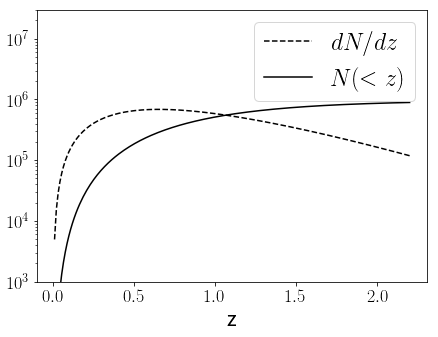

In [95]:
ztab = np.linspace(0.01, 2.2,200)
nsig=4
Flux = n * Ssys(ztab, CLAR) #we require an n-sigma detection


dNdztab = dNdz(ztab, nsig, CLAR)
Ntab = N_HI(ztab, nsig, CLAR)

fig = P.figure(); ax = fig.add_subplot(111);
ax.semilogy(ztab, dNdztab, ls = "--", color = "black", label = r"$dN/dz$" )
ax.semilogy(ztab, Ntab, color = "black", label = r"$N(<z)$")

ax.set_ylim((1e3, 3e7))
ax.set_xlabel("z")

P.legend(loc = "upper right")



Now we test the convergence of the differentiation of $\frac{dF}{dz}$ (and $\frac{dN}{dF} = \frac{dN}{dz} \bigl( \frac{dF}{dz}\bigr)^{-1}$, respectively):

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


Text(0,0.5,u'relative error on diff. of F')

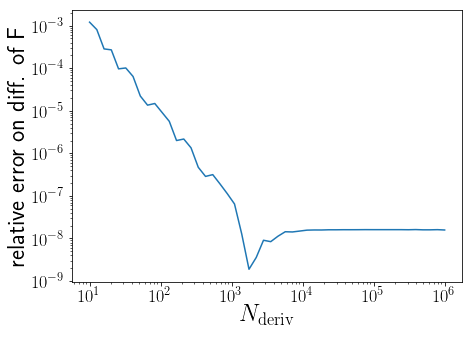

In [96]:
nder = np.logspace(1,6, 5)
z= 0.5; n = 4

deriv_best = dNdF(z, n, CLAR, Nderiv = 1e8)
# deriv_best = dFdz(z, n, CLAR, Nderiv = 1e7)

derivtab = [ dNdF(z, n, CLAR, Nderiv = nn) for nn in nder]
# derivtab = [ dFdz(z, n, CLAR, Nderiv = nn) for nn in nder]
derivtab = np.array(derivtab)

fig = P.figure(); ax = fig.add_subplot(111);
ax.loglog(nder, np.abs((derivtab - deriv_best)/deriv_best))

ax.set_xlabel(r"$N_\mathrm{deriv}$")
ax.set_ylabel("relative error on diff. of F")

I think that $N_\mathrm{deriv} = 1000$ is enough.

Now, the crux, we try to plot $\alpha$ as in fig 4. At this moment I am still not sure how to calculate it. It is defined as $\alpha = -f'(>F_c) F_c / f(>F_c)$, where $f(>F)$ is the fraction of galaxies above flux $F$. The derivative $'$ is with respect to the flux limit.
My line of thought is the following:
if $N(>F)$ is the number of galaxies above flux $F$ and $N_\mathrm{tot}$ is the total number of galaxies, then $f(>F)=N(>F)/N_\mathrm{tot}$. We know that $N_\mathrm{tot}$ is independent of $F$, therefore $f'(>F)=N'(>F)/N_\mathrm{tot}$ and $\alpha = -N'(>F_c) F_c / N(>F_c)$ because $N_\mathrm{tot}$ cancels. To do the actual calculation, we use that $\frac{dN}{dF} = \frac{dN}{dz} \bigl( \frac{dF}{dz} \bigr)^{-1}$. However, this does not seem to work. To check I also tried using $\frac{dN}{dz}$ instead of $N$, but it doesn't help.

We have basically two possibilities now:


-1 I do not understand how to calculate $\alpha$

-2 There's a bug in the way I calculate $\alpha$

For now let's maybe focus on the fact that my $\alpha$ is always negative, whereas it should be $>1$.

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5,0,u'$z$')

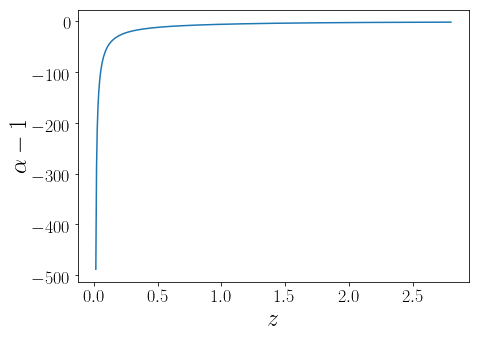

In [104]:
#now plot alpha (Fig 3&4):

z = np.linspace(0.01, 2.8, 500)
alphatab = alpha(z, nsig, CLAR)

fig = P.figure();
ax2 = fig.add_subplot(111)


# ax2.plot(z, alphatab-1)
ax2.plot(z, alphatab-1)

ax2.set_ylabel(r"$\alpha-1$")
ax2.set_xlabel(r"$z$")

The rest of this notebook is plotting the stuff from Alkistis' notes which seems to work (comparable to fig 5). First I have to get $\alpha$ right before I can compare to the quantities from Zhang&Pen directly.

In [33]:
#Calculate the HI X mag power spectrum Cls:
Cl_Hxm_tab = Cl_HIxmag_CAMB(ltab, zf, zb, dzf)


(0.0001, 0.1)

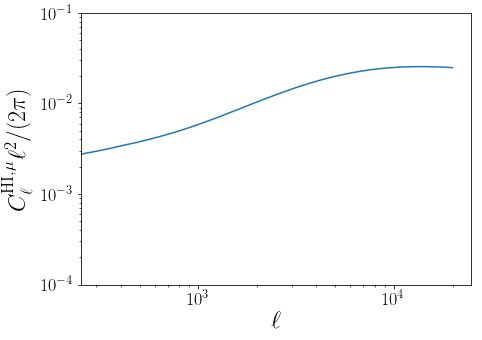

In [43]:
#plot it:
fig = P.figure(); ax = fig.add_subplot(111);

ax.loglog(ltab, Cl_Hxm_tab*ltab**2 / 2 / pi)

ax.set_xlabel("$\ell$")
ax.set_ylabel("$C_\ell^\mathrm{HI, \mu} \ell^2/(2\pi)$")

ax.set_xlim((250,25000))
ax.set_ylim((1e-4, 1e-1))


I think our $C_\ell^\mathrm{HI, mag}$ should match $C_\ell^{\mu g}$ Fig. 5 in Zhang&Pen up to a constant factor, which it does! We are about a factor of 2 off. The $\ell$ dependence is totally different if we use BBKS, but not if we use CAMB.

[Their $\ell$ dependece is $C_\ell^{\mu g} \sim \Delta_m^2(\ell/r(z_f), z_f) / l^3$.

For us it's $C_\ell^\mathrm{HI, mag} \sim P((\ell + 1/2)/r(z),z))$.

NOW: signal to noise for perfect survey:

In [18]:
##making new zf:
# zfs = np.linspace(0.8,zb - 2*dzb,5)
# dzf = 0.05

#using the same one as above:
zfs = np.array([zf])

lstart = 10; lend = 20000; lN = 50
# ltab = np.linspace(lstart, lend, lN, dtype = int)
ltab = np.logspace(np.log10(lstart), np.log10(lend), lN, dtype = int)

S2N_p_tab = []
Delta_Cl_p_tab = []
for zzf in zfs:
    print "foreground from {} to {}".format(zzf-dzf, zzf+dzf)

    S2N_p_tab.append( S2N(ltab, zzf, dzf, zb, dzb, PERFECT_SURVEY=1) )
#     Delta_Cl_p_tab.append( DELTA_Cl_HIxmag(ltab, zzf, dzf, zb, dzb, PERFECT_SURVEY=1))
    
print "background from {} to {}".format(zb-dzb, zb+dzb)


foreground from 0.5 to 1.0
background from 1.5 to 1.9


In [19]:
# S2Narr = np.array(S2N_p_tab)

# fig = P.figure(); ax = fig.add_subplot(111);

# ax.plot(zfs, S2Narr[:,0], label = "l = {}".format(ltab[0]))
# ax.plot(zfs, S2Narr[:,10], label = "l = {}".format(ltab[10]))
# ax.plot(zfs, S2Narr[:,19], label = "l = {}".format(ltab[19]))


# ax.set_xlabel("$z_f$")
# ax.set_ylabel("S2N")
# P.legend()

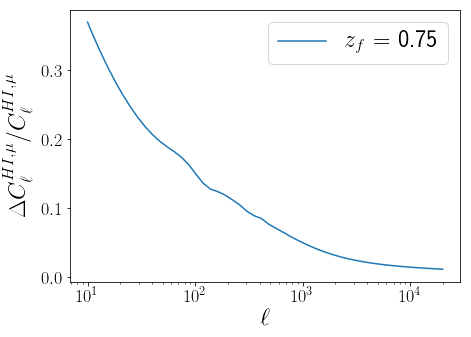

In [20]:
#plot DeltaCl / Cl:

fig = P.figure(); ax1 = fig.add_subplot(111); 

for i in range(len(S2N_p_tab)):
    ax1.semilogx(ltab, 1/S2N_p_tab[i], label = "$z_f$ = {}".format(np.around(zfs[i],2)))

ax1.set_ylabel("$\Delta C_\ell^{HI,\mu} / C_\ell^{HI,\mu}$")
ax1.set_xlabel("$\ell$")
ax1.legend()


This is very low, but it's for a perfect survey. Let's now implement shot and white noise, fsky, and the $\ell$ binning and set the boolean 'perfect_survey' to False!